In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import random
import numpy as np 
import numpy.matlib as matlib
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
train_images = train_images / 256.0
test_images = test_images / 256.0

In [3]:
float_formatter = "{:.2f}".format

In [4]:
# plot functions
def plot_flat_images(images, dim, items=16, cmap=plt.cm.viridis):
    plt.figure(figsize=(10, np.ceil(items/16)*10))
    for i in range(items):
        plt.subplot(np.ceil(items/4), 4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].reshape(dim), cmap)
    plt.show()
    
def plot_vector(vector, cmap=plt.cm.viridis, colorBar=False):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(vector.reshape(1, vector.shape[0]), cmap)
    if colorBar:
        plt.colorbar()

In [5]:
# neural network helper functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def feedforward(a):
    """Return the output of the network if "a" is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [24]:
sizes = [28*28, 24, 10]
num_layers = len(sizes)
weights = [np.random.rand(y, x)*2-1 for x, y in zip(sizes[:-1], sizes[1:])]
biases = [np.random.rand(y, 1)*2-1 for y in sizes[1:]]

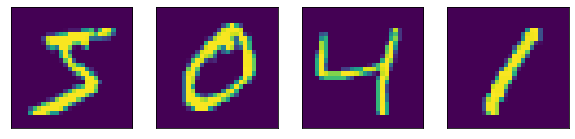

In [25]:
plot_flat_images(train_images, (train_images.shape[1], train_images.shape[2]), 4)

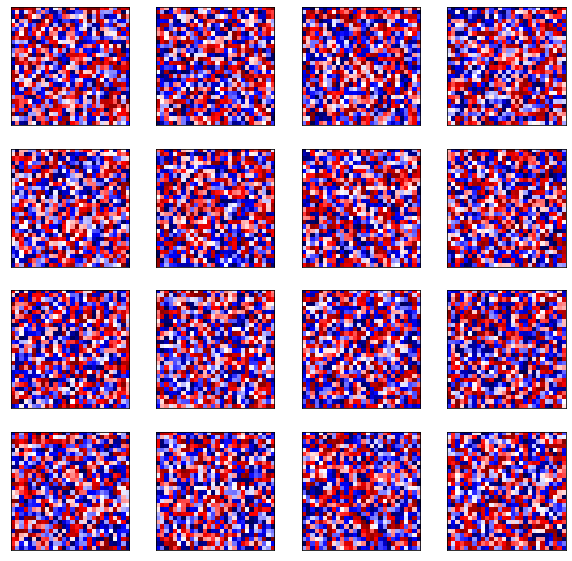

In [26]:
plot_flat_images(weights[0], (train_images.shape[1], train_images.shape[2]), 16, cmap=plt.cm.seismic)

In [27]:
def SGD(training_data, epochs, mini_batch_size, eta,
        test_data=None):
    """Train the neural network using mini-batch stochastic
    gradient descent.  The ``training_data`` is a list of tuples
    ``(x, y)`` representing the training inputs and the desired
    outputs.  The other non-optional parameters are
    self-explanatory.  If ``test_data`` is provided then the
    network will be evaluated against the test data after each
    epoch, and partial progress printed out.  This is useful for
    tracking progress, but slows things down substantially."""

    training_data = list(training_data)
    n = len(training_data)

    if test_data:
        test_data = list(test_data)
        n_test = len(test_data)

    for j in range(epochs):
        random.shuffle(training_data)
        mini_batches = [
            training_data[k:k+mini_batch_size]
            for k in range(0, n, mini_batch_size)]
        for mini_batch in mini_batches:
            update_mini_batch(mini_batch, eta)
        if test_data:
            print("Epoch {} : {} / {}".format(j, evaluate(test_data),n_test))
        else:
            print("Epoch {} complete".format(j))
            
def update_mini_batch(mini_batch, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights, biases
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    weights = [w-(eta/len(mini_batch))*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/len(mini_batch))*nb
                   for b, nb in zip(biases, nabla_b)]

def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    global weights, biases, num_layers
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    # backward pass
    delta = cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    # Note that the variable l in the loop below is used a little
    # differently to the notation in Chapter 2 of the book.  Here,
    # l = 1 means the last layer of neurons, l = 2 is the
    # second-last layer, and so on.  It's a renumbering of the
    # scheme in the book, used here to take advantage of the fact
    # that Python can use negative indices in lists.
    for l in range(2, num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)


def evaluate(test_data):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    test_results = [(np.argmax(feedforward(x)), y)
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)

def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

In [28]:
training_inputs = [np.reshape(x, (784, 1)) for x in train_images]
training_results = [vectorized_result(y) for y in train_labels]
training_data = list(zip(training_inputs, training_results))

test_inputs = [np.reshape(x, (784, 1)) for x in test_images]
test_data = zip(test_inputs, test_labels)

In [29]:
SGD(training_data, epochs=10, mini_batch_size=10, eta=3.0, test_data=test_data)

Epoch 0 : 9262 / 10000
Epoch 1 : 9329 / 10000
Epoch 2 : 9356 / 10000
Epoch 3 : 9339 / 10000
Epoch 4 : 9363 / 10000
Epoch 5 : 9395 / 10000
Epoch 6 : 9456 / 10000
Epoch 7 : 9430 / 10000
Epoch 8 : 9463 / 10000
Epoch 9 : 9445 / 10000


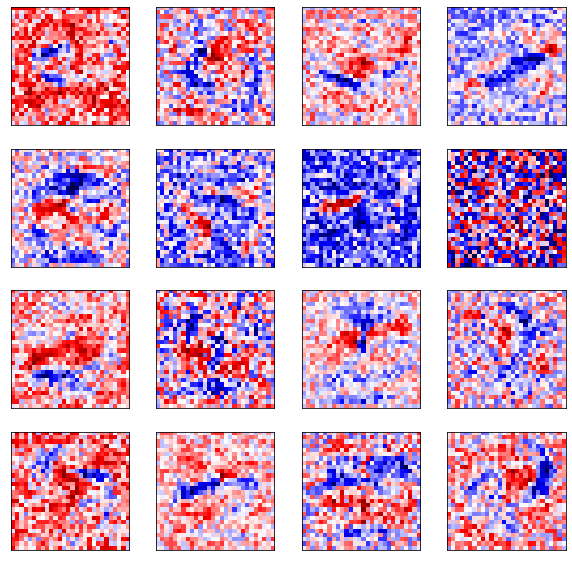

In [30]:
plot_flat_images(weights[0], (train_images.shape[1], train_images.shape[2]), cmap=plt.cm.seismic)

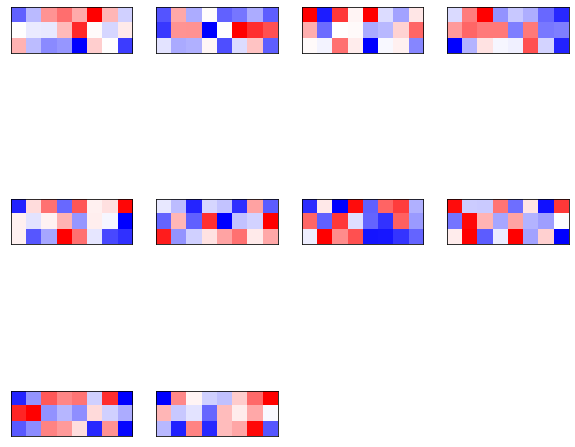

In [13]:
plot_flat_images(weights[1], (3, 8), 10, cmap=plt.cm.bwr)

In [14]:
plot_flat_images(weights[2], (4, 4), 10, cmap=plt.cm.bwr)

IndexError: list index out of range

In [15]:
np.argmax(feedforward(training_inputs[0]))

5

In [16]:
np.set_printoptions(formatter={'float_kind':float_formatter})
np.reshape(feedforward(training_inputs[0]), (10))

array([0.00, 0.00, 0.00, 0.02, 0.00, 0.99, 0.00, 0.00, 0.00, 0.00])